# Kagome design (3dp pla + blue shims) for energy focusing with single target region


## Imports

NOTE: Please download data associated to this repository from https://doi.org/10.5281/zenodo.12823471


In [9]:
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

from problems.kagome_focusing import ForwardProblem, OptimizationProblem
from difflexmm.geometry import compute_inertia
from difflexmm.plotting import generate_animation, plot_geometry
from difflexmm.utils import save_data, load_data, SolutionData
from pathlib import Path
from typing import Optional, Any
import matplotlib
import matplotlib.pyplot as plt

plt.style.use(["science", "grid"])
%matplotlib widget


## Plotting functions

In [10]:
def plot_objective_and_constraints_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, figsize=(10, 7), fontsize=None, grid=True):

    fig, axes = plt.subplots(nrows=3, figsize=figsize,
                             sharex=True, constrained_layout=True)
    axes[0].set_ylabel("Energy focused [mJ]", fontsize=fontsize)
    axes[0].plot(jnp.array(optimization.objective_values) /
                 optimization.forward_problem.n_timepoints, lw=3, color="#16a085")
    axes[0].axhline(y=0, color="black")
    axes[1].set_ylabel("Overlap", fontsize=fontsize)
    axes[1].plot(optimization.constraints_violation["angles"],
                 lw=3, color="#c0392b")
    axes[1].axhline(y=0, color="black")
    axes[2].set_ylabel("Edge-length [mm]", fontsize=fontsize)
    axes[2].plot(optimization.constraints_violation["edge_lengths"],
                 lw=3, color="#c0392b")
    axes[2].axhline(y=0, color="black")
    axes[-1].set_xlabel(r"Iteration \#", fontsize=fontsize)
    # Change fontsize for all axes
    for ax in axes:
        ax.tick_params(labelsize=fontsize)
    if not grid:
        for ax in axes:
            ax.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_and_constraints_iterations.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)
    return fig, axes


def generate_response_animation(
        optimization: OptimizationProblem,
        optimization_filename: str,
        animation_filename: str = "response_animation",
        iteration=-1,
        field: str = "v",
        **plot_kwargs):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    if iteration >= 0:
        solution = optimization.forward_problem.solve(
            optimization.design_values[iteration]
        )
    else:
        solution = optimization.forward_problem.solution_data if optimization.forward_problem.solution_data is not None else optimization.forward_problem.solve(
            optimization.design_values[iteration]
        )

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + optimization.forward_problem.cell_size * jnp.array([[-1.25, 1.25], [-1., 1.]])

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    # Drop alien stuff from plot_kwargs
    plot_kwargs.pop("field", None)
    plot_kwargs.pop("animation_filename", None)
    plot_kwargs.pop("iteration", None)
    generate_animation(
        data=solution,
        field=field,
        out_filename=f"../out/{optimization.name}/{optimization_filename}/{animation_filename}_design_{iteration_label:03d}",
        deformed=True,
        # xlim=xlim,
        # ylim=ylim,
        **plot_kwargs
    )


def plot_design(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, design_label: Optional[str] = None, iteration=-1, figsize=(10, 7), fontsize=None, grid=True, axis=True, field_values=None, cmap: Any = "inferno", color=None, cmap_label=None, scaling=1., deformed=False, block_displacements=None, vmin=None, vmax=None):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + 0.25*optimization.forward_problem.cell_size * jnp.array([[-1., 1.], [-0.5, 0.5]])

    fig, axes = plot_geometry(
        block_centroids=optimization.forward_problem.geometry.block_centroids(
            *optimization.design_values[iteration]),
        centroid_node_vectors=optimization.forward_problem.geometry.centroid_node_vectors(
            *optimization.design_values[iteration]),
        bond_connectivity=optimization.forward_problem.geometry.bond_connectivity(),
        deformed=deformed,
        block_displacements=block_displacements,
        figsize=figsize,
        color="#2980b9",
        xlim=xlim,
        ylim=ylim,
    )
    axes.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    axes.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
    # axes.set_aspect("equal")
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)
    if not axis:
        axes.axis("off")

    if field_values is not None and color is None:
        axes.collections[0].set_array(field_values)
        axes.collections[0].set_cmap(cmap)
        axes.collections[0].set_norm(
            matplotlib.colors.PowerNorm(
                gamma=scaling,
                vmin=jnp.min(field_values) if vmin is None else vmin,
                vmax=jnp.max(field_values) if vmax is None else vmax,
            )
        )
        cb = fig.colorbar(axes.collections[0], ax=axes, pad=0.01, aspect=30)
        cb.ax.tick_params(
            labelsize=0.8*fontsize if fontsize is not None else None)
        # Set ticklabels to have 1 decimal place
        cb.set_ticks(cb.get_ticks())
        cb.set_ticklabels([f"{tick:.1f}" for tick in cb.get_ticks()])
        cb.set_label(cmap_label, fontsize=fontsize)

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    if optimization_filename is not None:
        _design_label = f"design_{iteration_label:03d}_{design_label}" if design_label is not None else f"design_{iteration_label:03d}"
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/{_design_label}.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)

    return fig, axes


def kinetic_energy_per_block(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def average_kinetic_energy_per_block(solution_data, blocks_inertia):
    return jnp.sum(
        kinetic_energy_per_block(
            solution_data.fields[:, 1],
            blocks_inertia,
        )/solution_data.timepoints.shape[0],
        axis=0,
    )

## Optimal design and response


In [11]:
# NOTE: Units are mm, N, s

# Geometrical params
n1_cells = 20
n2_cells = 12
cell_size = 20.  # 20 mm
cell_angle = jnp.pi/3  # 60 degrees
hinge_length = 2.25  # 2.25 mm
# Initial design
shifts_1 = jnp.zeros((n1_cells+1, n2_cells, 2))  # Perfect kagome
shifts_2 = jnp.zeros((n1_cells, n2_cells+1, 2))
shifts_3 = jnp.zeros((n1_cells, n2_cells, 2))

# Mechanical params
k_stretch = 120.  # stretching stiffness 120. N/mm
k_shear = 1.19  # shearing stiffness 1.19 N/mm
k_rot = 1.50  # rotational stiffness 1.50 Nmm
density = 6.18e-9  # Mg/mm^2
# NOTE: Damping is assumed to be the same for all blocks as it is small enough that the inertia change during optimization is negligible.
damping = 0.0186 * jnp.array([
    2 * (0.070175913225 * density * cell_size**2 * k_shear)**0.5,
    2 * (0.070175913225 * density * cell_size**2 * k_shear)**0.5,
    2 * (0.0009477510275 * density * cell_size**4 * k_rot)**0.5
]) * jnp.ones((2*n1_cells*n2_cells, 3))

# Dynamic loading
amplitude = 0.5 * cell_size
loading_rate = 30.  # Hz loading frequency for dynamic input

# Forward problem
problem = ForwardProblem(
    # Geometrical params
    n1_cells=n1_cells,
    n2_cells=n2_cells,
    cell_size=cell_size,
    cell_angle=cell_angle,
    bond_length=hinge_length,
    # Mechanical params
    k_stretch=k_stretch,
    k_shear=k_shear,
    k_rot=k_rot,
    density=density,
    damping=damping,
    use_contact=True,
    k_contact=k_rot,
    min_angle=-15*jnp.pi/180,
    cutoff_angle=-10*jnp.pi/180,
    # Dynamic loading
    amplitude=amplitude,
    loading_rate=loading_rate,
    input_delay=0.1*loading_rate**-1,
    n_excited_blocks=2,
    loaded_side="left",
    input_shift=0,
    # Analysis params
    simulation_time=3*loading_rate**-1,  # s
    n_timepoints=200,
    # Solver tolerances
    atol=1e-4,
    # Problem name (folder name)
    name="kagome_focusing_3dp_pla_shims",
)

# Optimization problem
target_size = (2, 2)  # target size in number of cells
target_shift = (3, 2)  # target shift in number of cells from the center
optimization = OptimizationProblem(
    forward_problem=problem,
    target_size=target_size,
    target_shift=target_shift,
    name=problem.name,
)

problem_filename = f"kagome{'_linearized_strains' if problem.linearized_strains else ''}_{problem.n1_cells}x{problem.n2_cells}_excited_blocks_{problem.n_excited_blocks}_cell_size_{problem.cell_size:.2f}_cell_angle_{problem.cell_angle*180/jnp.pi:.1f}_amplitude_{problem.amplitude:.2f}_loading_rate_{problem.loading_rate:.2f}_input_shift_{problem.input_shift}"
optimization_filename = f"opt_with_angle_10_and_length_3_constraints_{problem_filename}_target_size_{optimization.target_size[0]}x{optimization.target_size[1]}_target_shift_{optimization.target_shift[0]}x{optimization.target_shift[1]}"

### Import most recent optimization object


In [12]:
# NOTE: Data can be downloaded from https://doi.org/10.5281/zenodo.12823471
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Run optimization


In [ ]:
# optimization.run_optimization_nlopt(
#     initial_guess=((shifts_1, shifts_2, shifts_3)),
#     # initial_guess=optimization.design_values[-1],
#     n_iterations=30,
#     min_block_angle=10*jnp.pi/180,
#     min_void_angle=0*jnp.pi/180,
#     min_edge_length=3.,  # mm
#     max_time=8*60*60,  # 8 hour
#     # lower_bound=-0.22*optimization.forward_problem.spacing,
#     # upper_bound=0.22*optimization.forward_problem.spacing,
# )

# save_data(
#     f"../data/{optimization.name}/{optimization_filename}.pkl",
#     optimization.to_dict()  # Optimization problem
# )


## Plots


### Objective iterations


In [ ]:
plot_objective_and_constraints_iterations(
    optimization,
    optimization_filename=optimization_filename,
    figsize=(7, 6),
    fontsize=14,
)


### Response animation


In [ ]:
# Initial design
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=optimization_filename,
    figsize=(10, 4),
    xlim=(-1*cell_size, 26*cell_size),
    ylim=(-0.5*cell_size, 11*cell_size),
    fontsize=14,
    fps=20,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=0,
)

In [ ]:
# Best design
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=optimization_filename,
    figsize=(10, 4),
    xlim=(-1*cell_size, 26*cell_size),
    ylim=(-0.5*cell_size, 11*cell_size),
    fontsize=14,
    fps=20,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=-1,
)

### Plot designs

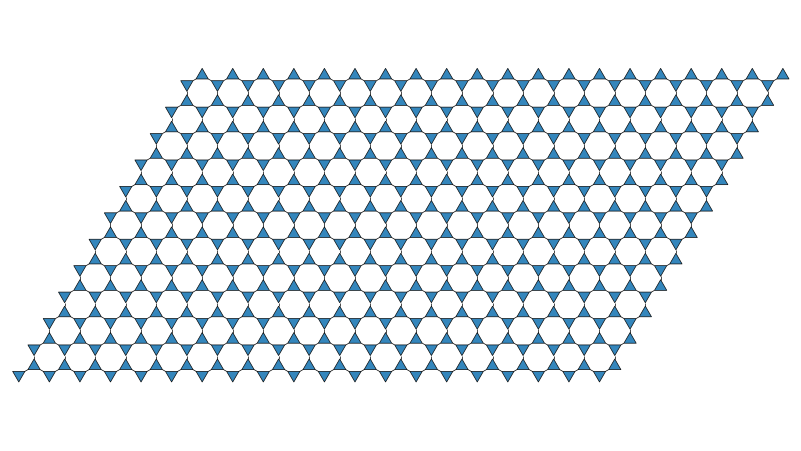

In [5]:
# Initial design
iteration = 0
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    figsize=(8, 4.5),
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

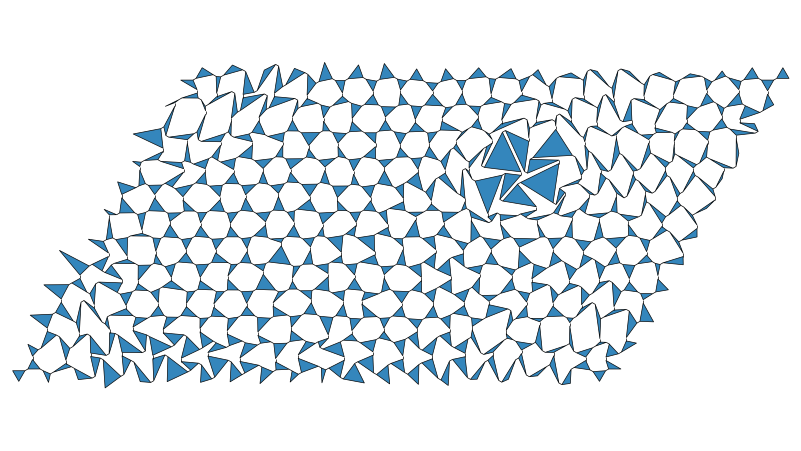

In [6]:
# Best design
iteration = -1
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    figsize=(8, 4.5),
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

### Plot average kinetic energy distribution


In [ ]:
# Initial design
iteration = 0
solution_data = optimization.forward_problem.solve(
    optimization.design_values[iteration])
design_label = f"average_kinetic_energy"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(8, 4.5),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    vmin=0,
    vmax=1.2,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

In [ ]:
# Intermidiate design
iteration = 6
solution_data = optimization.forward_problem.solve(
    optimization.design_values[iteration])
design_label = f"average_kinetic_energy"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(8, 4.5),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    vmin=0,
    vmax=1.2,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

In [ ]:
# Intermidiate design
iteration = 9
solution_data = optimization.forward_problem.solve(
    optimization.design_values[iteration])
design_label = f"average_kinetic_energy"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(8, 4.5),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    vmin=0,
    vmax=1.2,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

In [ ]:
# Intermidiate design
iteration = 14
solution_data = optimization.forward_problem.solve(
    optimization.design_values[iteration])
design_label = f"average_kinetic_energy"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(8, 4.5),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    vmin=0,
    vmax=1.2,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

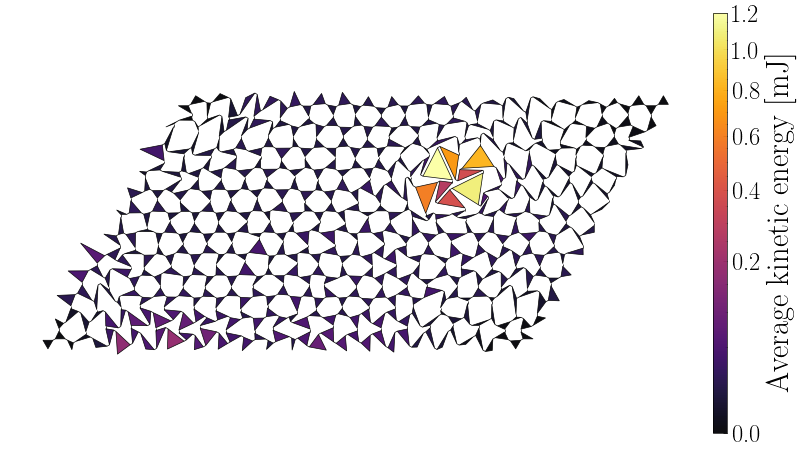

In [17]:
# Best design
iteration = -1
solution_data = optimization.forward_problem.solution_data
design_label = f"average_kinetic_energy"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"{optimization_filename}",
    design_label=design_label,
    figsize=(8, 4.5),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    vmin=0,
    vmax=1.2,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
    iteration=iteration,
)

## Sweep contact angle

### Import optimization object

In [14]:
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Contact params to sweep

In [15]:
contact_params_sweep = dict(
    min_angle=jnp.array([-15, -10, -5, -2])*jnp.pi/180,
    cutoff_angle=jnp.array([-10, -5, 0, 0])*jnp.pi/180,
)

### Run sweep

In [28]:
for min_angle, cutoff_angle in zip(contact_params_sweep["min_angle"], contact_params_sweep["cutoff_angle"]):
    sweep_filename = f"min_angle_{min_angle*180/jnp.pi:.1f}_cutoff_angle_{cutoff_angle*180/jnp.pi:.1f}"
    optimization.forward_problem.min_angle = min_angle
    optimization.forward_problem.cutoff_angle = cutoff_angle
    optimization.forward_problem.setup()
    solution_data = optimization.forward_problem.solve(optimization.design_values[-1])
    save_data(
        f"../data/{optimization.name}/{optimization_filename}/contact_params_sweep/{sweep_filename}.pkl",
        solution_data._asdict()  # Forward solution
    )

Data saved at ../data/kagome_focusing_3dp_pla_shims/opt_with_angle_10_and_length_3_constraints_kagome_20x12_excited_blocks_2_cell_size_20.00_cell_angle_60.0_amplitude_10.00_loading_rate_30.00_input_shift_0_target_size_2x2_target_shift_3x2/contact_params_sweep/min_angle_-15.0_cutoff_angle_-10.0.pkl
Data saved at ../data/kagome_focusing_3dp_pla_shims/opt_with_angle_10_and_length_3_constraints_kagome_20x12_excited_blocks_2_cell_size_20.00_cell_angle_60.0_amplitude_10.00_loading_rate_30.00_input_shift_0_target_size_2x2_target_shift_3x2/contact_params_sweep/min_angle_-10.0_cutoff_angle_-5.0.pkl
Data saved at ../data/kagome_focusing_3dp_pla_shims/opt_with_angle_10_and_length_3_constraints_kagome_20x12_excited_blocks_2_cell_size_20.00_cell_angle_60.0_amplitude_10.00_loading_rate_30.00_input_shift_0_target_size_2x2_target_shift_3x2/contact_params_sweep/min_angle_-5.0_cutoff_angle_0.0.pkl
Data saved at ../data/kagome_focusing_3dp_pla_shims/opt_with_angle_10_and_length_3_constraints_kagome_20x12

### Generate animations

In [ ]:
for min_angle, cutoff_angle in zip(contact_params_sweep["min_angle"], contact_params_sweep["cutoff_angle"]):
    solution_data = SolutionData(**load_data(
        f"../data/{optimization.name}/{optimization_filename}/contact_params_sweep/min_angle_{min_angle*180/jnp.pi:.1f}_cutoff_angle_{cutoff_angle*180/jnp.pi:.1f}.pkl",
    ))
    generate_animation(
        data=solution_data,
        field="v",
        out_filename=f"../out/{optimization.name}/{optimization_filename}/contact_params_sweep/min_angle_{min_angle*180/jnp.pi:.1f}_cutoff_angle_{cutoff_angle*180/jnp.pi:.1f}",
        deformed=True,
        figsize=(10, 4),
        xlim=(-1*cell_size, 26*cell_size),
        ylim=(-0.5*cell_size, 11*cell_size),
        fontsize=14,
        fps=20,
        dpi=300,
        legend_label="Velocity [mm/s]",
        cmap="inferno",
        axis=False,
    )
